In [73]:
import sys
sys.path.append('../scripts')

import proplot as pplt
import pandas as pd
from helpers import *
from scipy import stats
import numpy as np
import random

In [74]:
def parse_data(buoy):
        df = era5_data(buoy)
        df.datetime = df.datetime.astype("datetime64[s]")
        df.index = df.datetime

        dt = pd.Series(df.datetime) - pd.Series(df.datetime).shift()
        dt = dt.dt.total_seconds()

        vx = (df.x_stere - df.x_stere.shift())/dt
        vy = (df.y_stere - df.y_stere.shift())/dt
        v = np.sqrt(vx**2 + vy**2)

        wind_vel = np.sqrt(df['10m_u_wind_mps']**2 + df['10m_v_wind_mps']**2)
        df = df.assign(drift_speed_mps = v, wind_speed_mps=wind_vel, vx= vx, vy=vy)
        return df.dropna()

era5_buoys = [f.split("_")[0] for f in os.listdir("../data/interp_buoys_era5/mosaic_dn1")]
buoy_datas = {}
for buoy in era5_buoys:
    buoy_datas[buoy] = parse_data(buoy)

In [94]:
def makeHist(groups, var1, var2, bins):
    fig, ax = pplt.subplots(figsize=(10,len(groups)*3), nrows=len(groups))
    for i, data in enumerate(groups):
        ax[i].hist(data[1][var2]/data[1][var1], bins=bins)
        ax[i].format(title=f"{data[0]}", xlocator="linear", xlabel=f"{var2}/{var1} ratio", ylabel="freq")

In [126]:
def plotJoint(groups, var1, var2, bins):
    fig, axs = pplt.subplots(ncols=len(groups), figsize=(15,7), sharex=False)
    colormap = pplt.Colormap(["white"]+["blue"])

    x_bins, y_bins = bins
    
    for i, group in enumerate(groups):
        title = group[0]
        data = group[1]
        
        #binned = stats.binned_statistic_2d(data[var1], data[var2], 1, "count", bins=bins)
        binned = np.histogram2d(data[var1],data[var2], bins=bins)[0].T
        
        print(binned)

        c = axs[i].pcolor(x_bins, y_bins, binned, cmap=colormap, discrete=False)
        fig.colorbar(c, ax=axs[i])
        axs[i].format(title=f"{title}", xlocator="linear", xlabel=var1, ylabel=var2)
        overlay = x_bins * 0.015
        axs[i].plot(x_bins, overlay)

In [89]:
def summaryStats(groups, var1, var2):
    summaries=[]
    for i, group in enumerate(groups):
        data = group[1]
        summary = {
            f"{var1} mean: ": data[var1].mean(),
            f"{var2} mean: ": data[var2].mean(),
            f"{var1} min: ": data[var1].min(),
            f"{var2} min: ": data[var2].min(),
            f"{var1} max: ": data[var1].max(),
            f"{var2} max: ": data[var2].max(),
            "# Observations: ": len(data)
        }
        summaries.append(pd.DataFrame(summary, index=[str(group[0])]).transpose())
    print(pd.concat(summaries, axis=1))

In [110]:
def jointDistribution(df:pd.DataFrame, 
                      var1:str, 
                      var2:str, 
                      category:str, 
                      cmap : pplt.Colormap,
                      bins : list[int] = [40,40]):
    vars = df[[var1, var2, category]]
    groups = vars.groupby(category)

    #x_bins = np.linspace(vars[var1].min(), vars[var1].max(), bins[0])
    #y_bins = np.linspace(vars[var2].min(), vars[var2].max(), bins[1])
    
    x_bins = np.linspace(0, 1.5, bins[0])
    y_bins = np.linspace(0, 3, bins[1])
    
    plotJoint(groups,var1,var2, bins=[x_bins, y_bins])
    makeHist(groups, var1, var2, bins=np.linspace(0,min((df[var2]/df[var1]).max(),0.07),100))
    summaryStats(groups, var1, var2)
    

array([[  1.,   6.,   9., ..., 163., 220., 209.],
       [  0.,   0.,   1., ...,  17.,  17.,  13.],
       [  0.,   0.,   3., ...,  11.,  13.,  10.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

array([[  4.,  11.,  19., ..., 444., 515., 487.],
       [  0.,   3.,   0., ...,  79.,  63.,  83.],
       [  1.,   0.,   3., ...,  31.,  38.,  35.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

array([[ 0.,  6.,  0., ..., 10., 31., 23.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

array([[ 0.,  1.,  1., ..., 49., 59., 75.],
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

,FalseFalse,FalseTrue,TrueFalse,TrueTrue
wind_speed_mps mean:,5.571859,6.602452,5.460435,6.316001
drift_speed_mps mean:,0.114823,0.148518,0.105324,0.123408
wind_speed_mps min:,0.022361,0.030000,0.060000,0.056569
drift_speed_mps min:,0.000039,0.000028,0.000354,0.000348
wind_speed_mps max:,20.845731,20.884427,14.821424,16.781192
drift_speed_mps max:,1.905791,1.923326,0.382721,4.730534
# Observations:,120360.000000,504623.000000,25729.000000,93201.000000


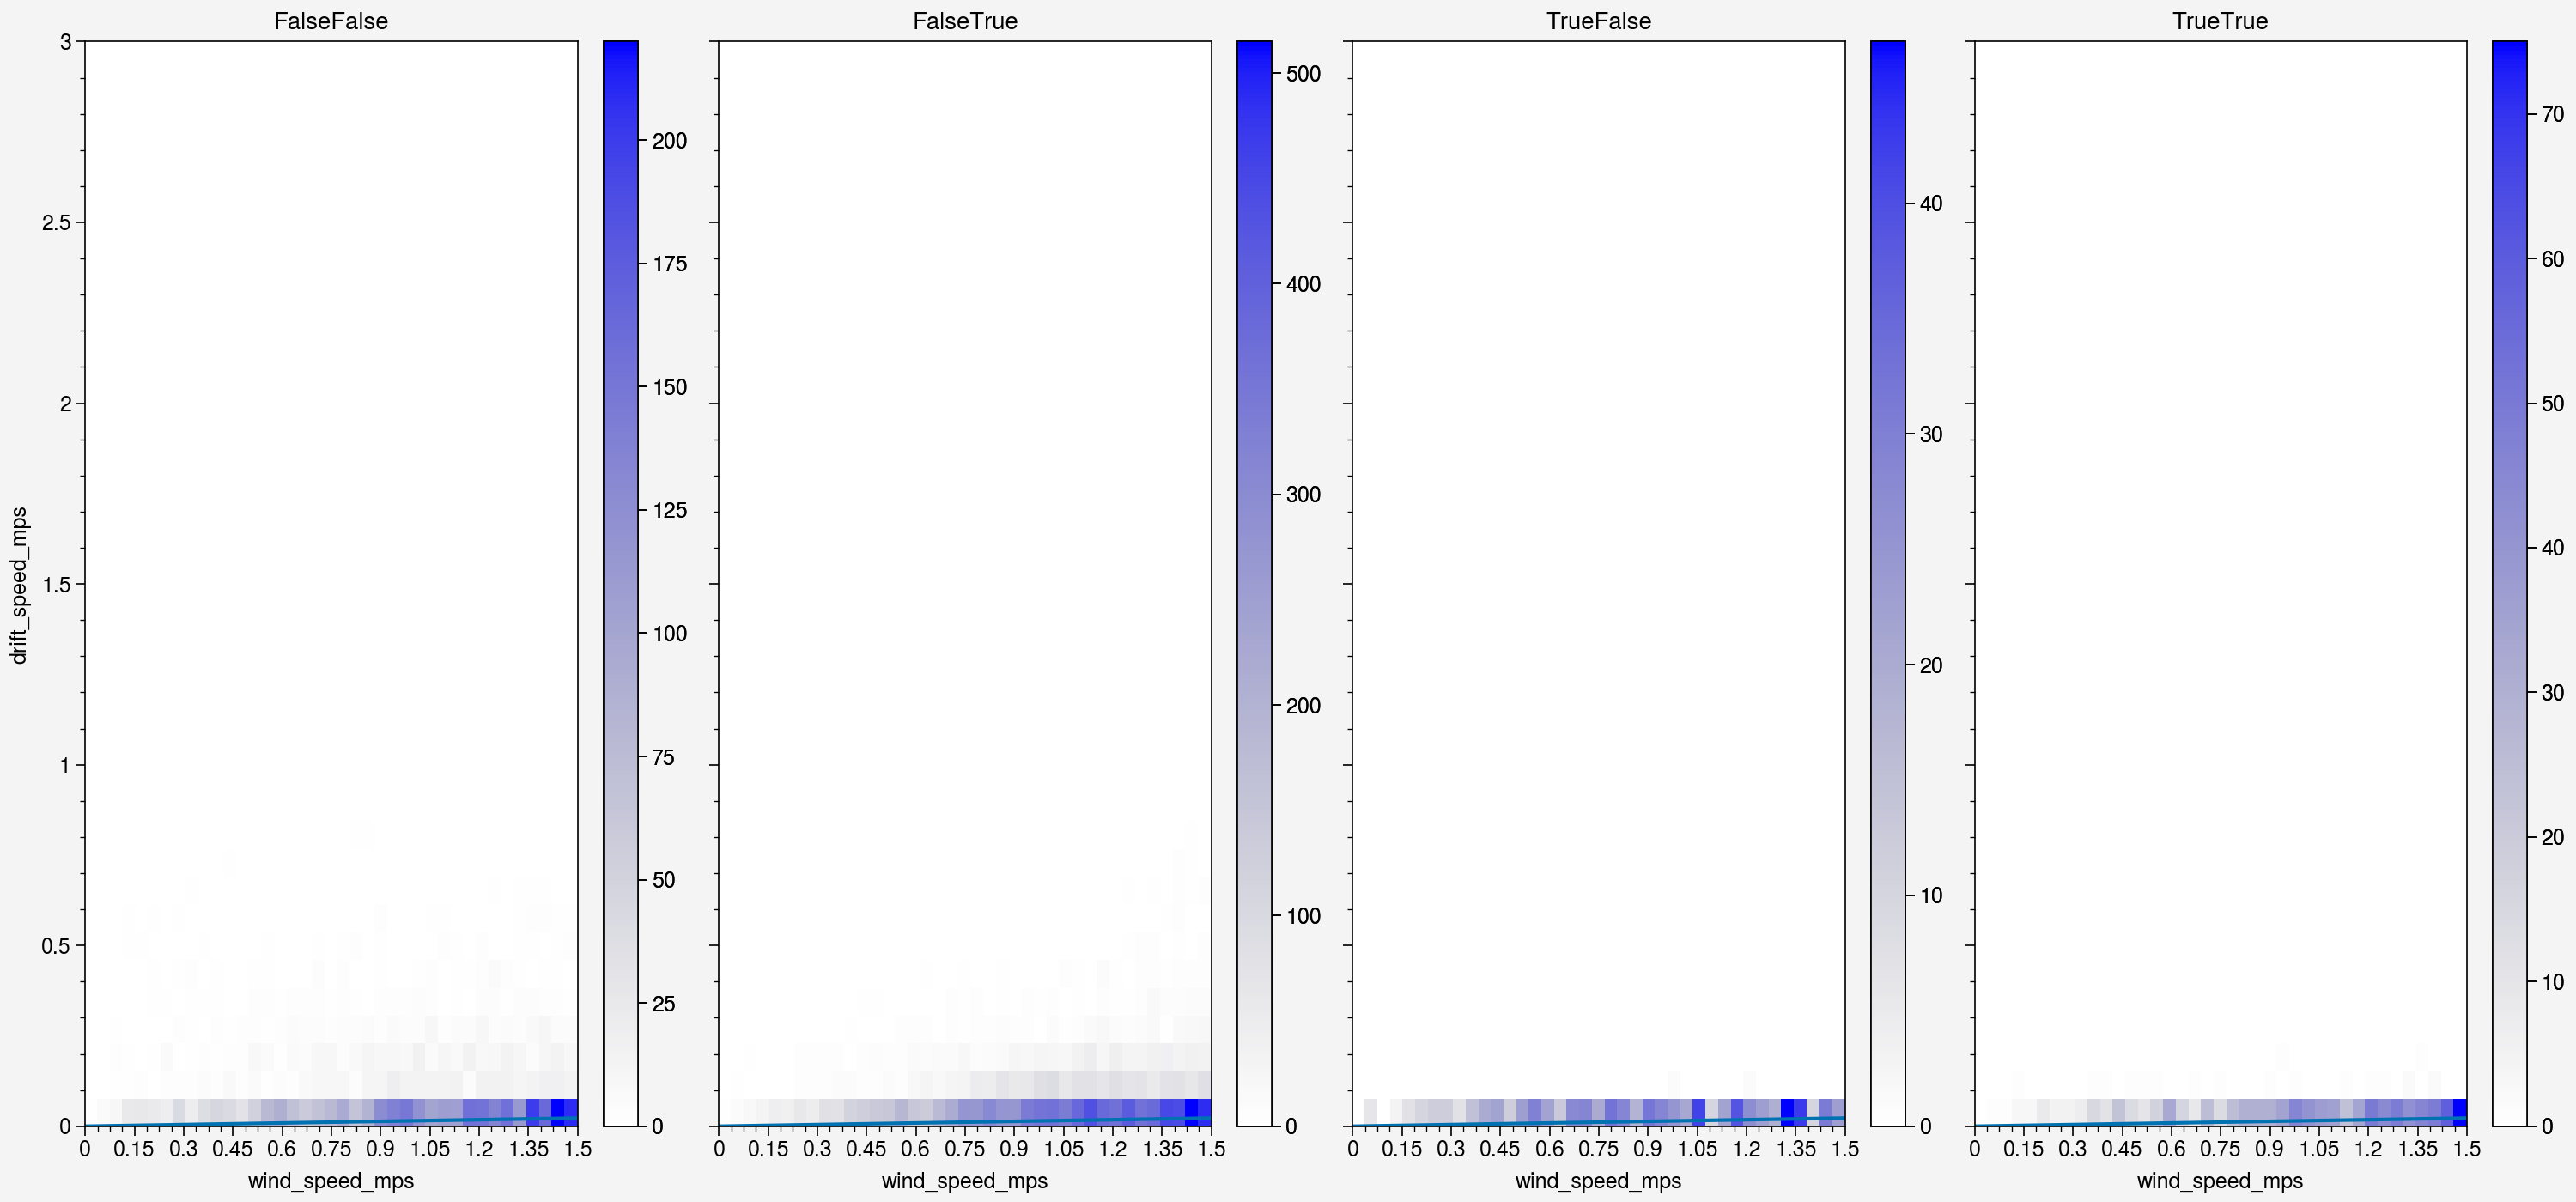

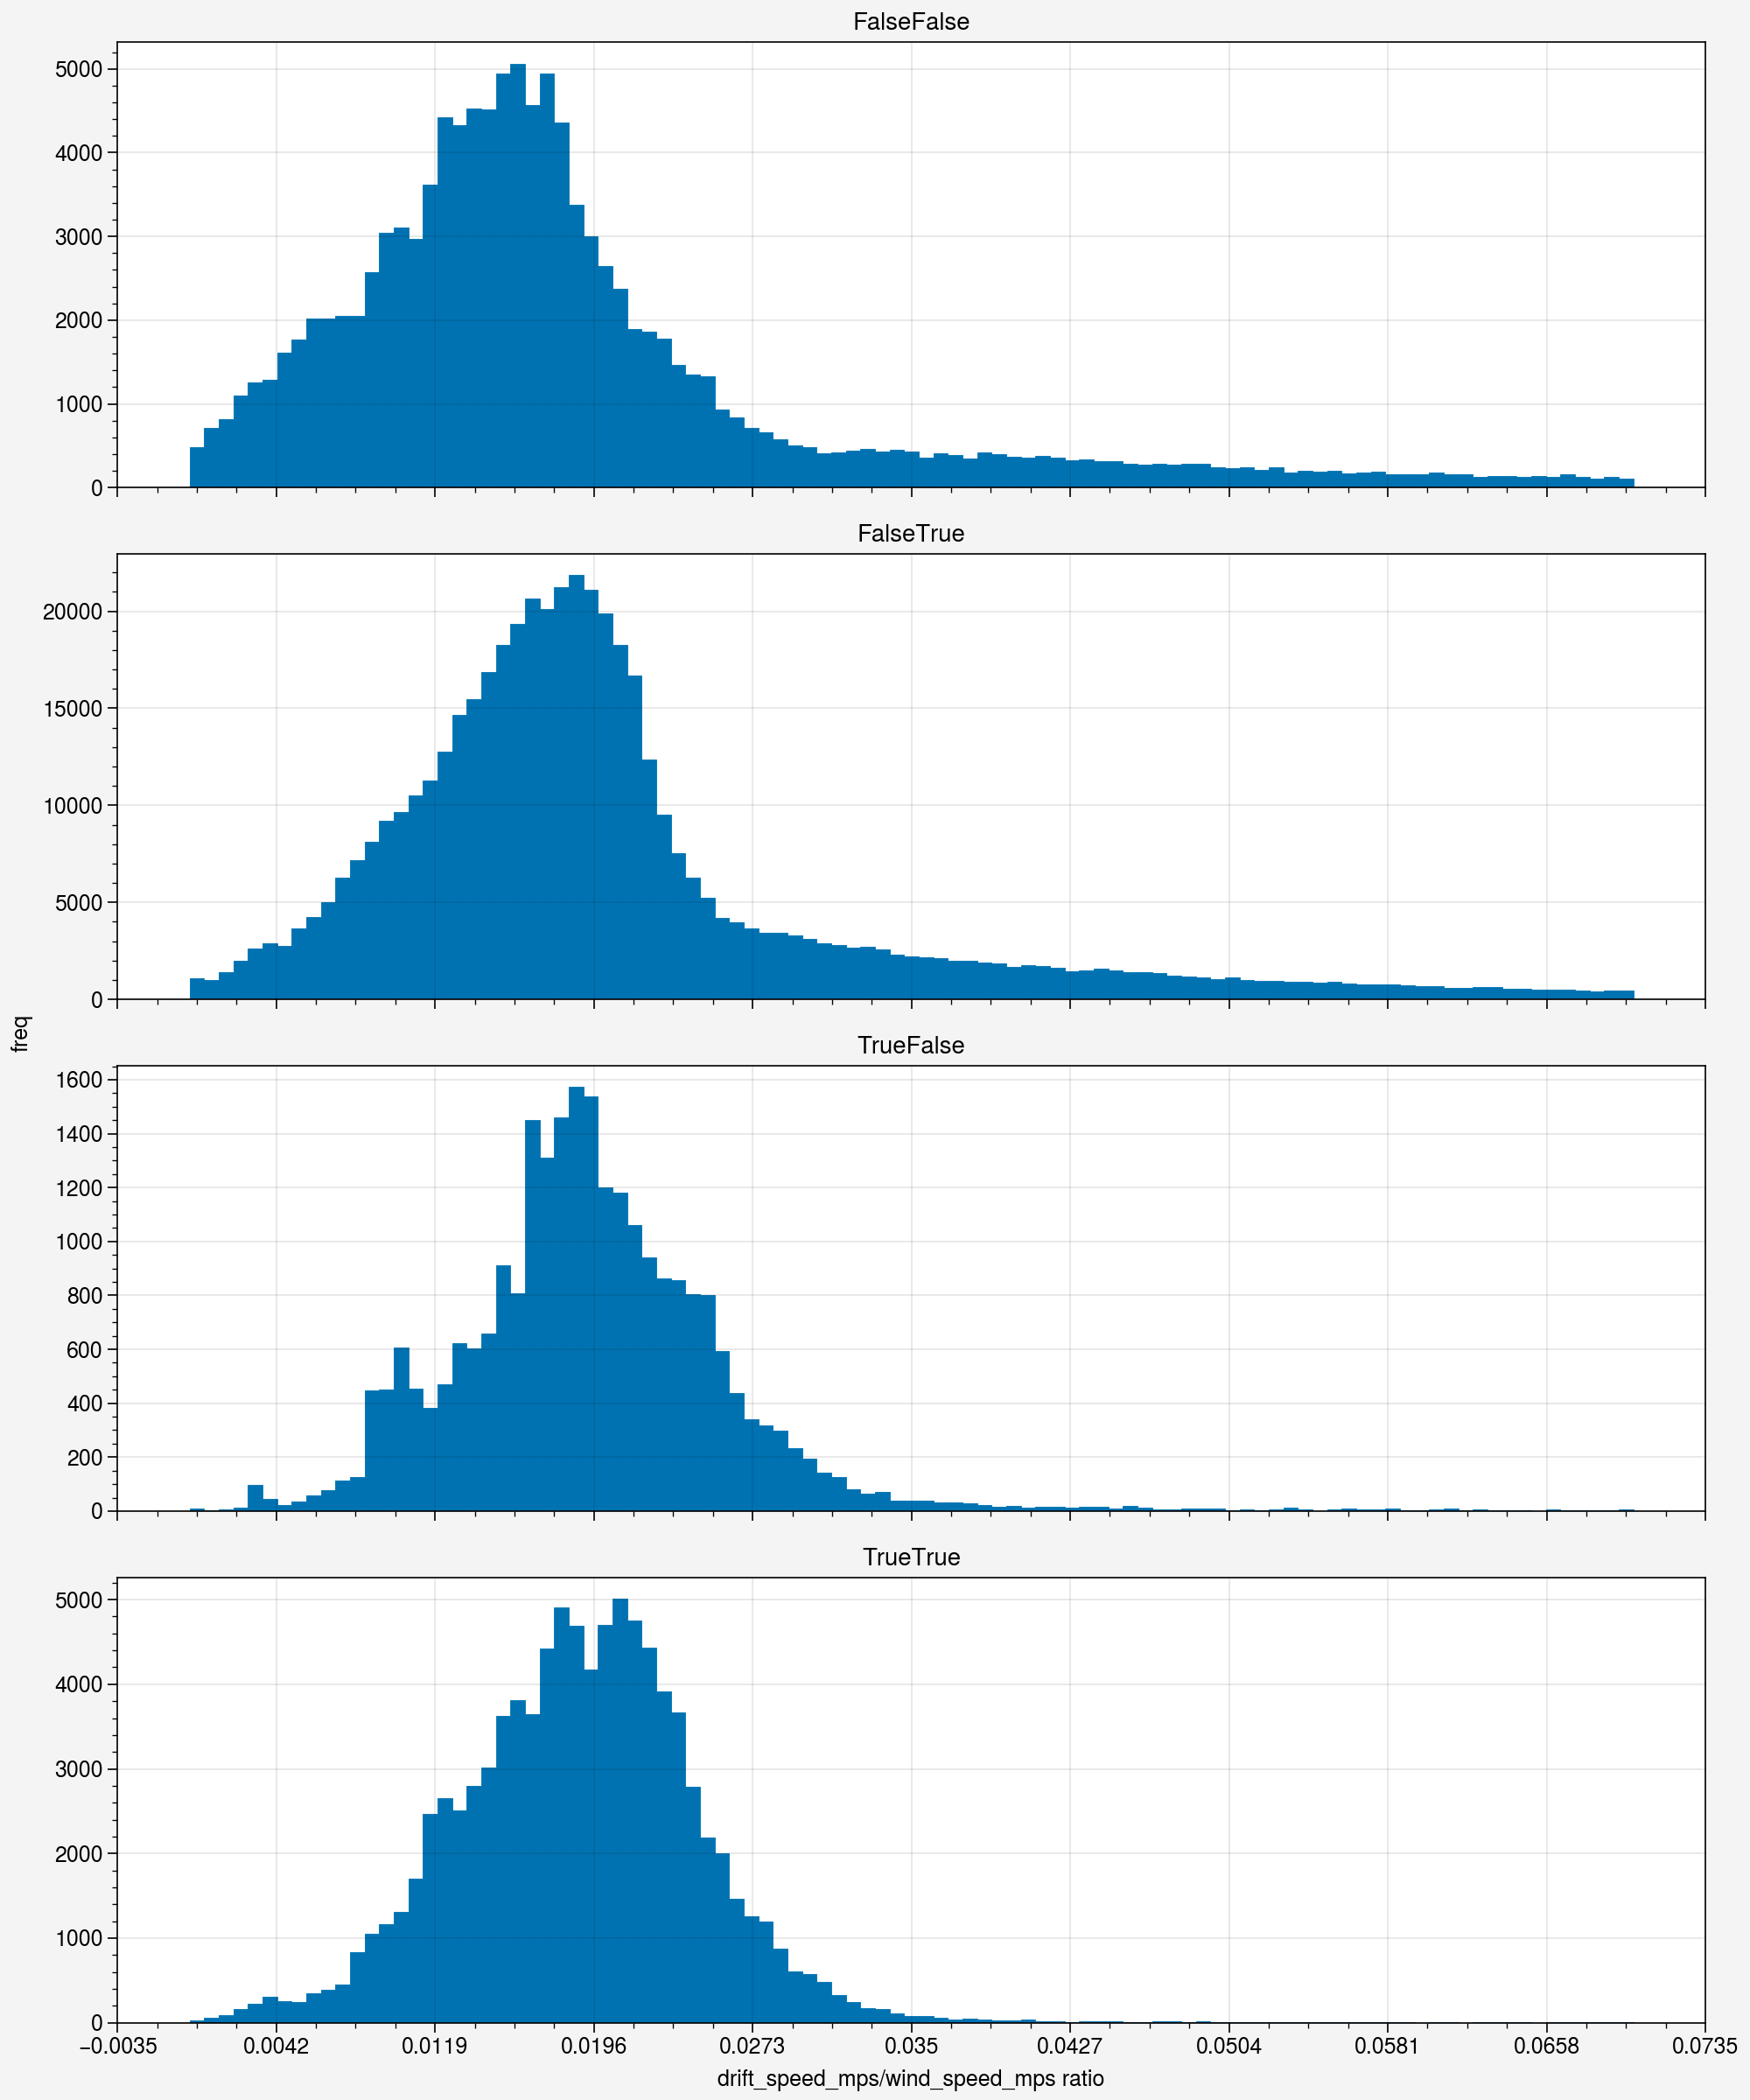

In [127]:
cloud_thresh = 95
cloud_label = f"clouds > {cloud_thresh}"


# df = buoy_datas["2019F4"]
#df = df[df["wind_speed_mps"] < 10]

df = pd.concat(list(buoy_datas.values()))


# df = df[df["wind_speed_mps"] > 6]
kwargs = {cloud_label : df.total_cloud_cover > cloud_thresh, "iswinter" : df.datetime < pd.to_datetime("2019-11-30")}
kwargs["highcloud - winter"] = kwargs["iswinter"].astype("str") + kwargs[cloud_label].astype("str")
df = df.assign(**kwargs)

jointDistribution(df, "wind_speed_mps", "drift_speed_mps", "highcloud - winter", [40, 40])

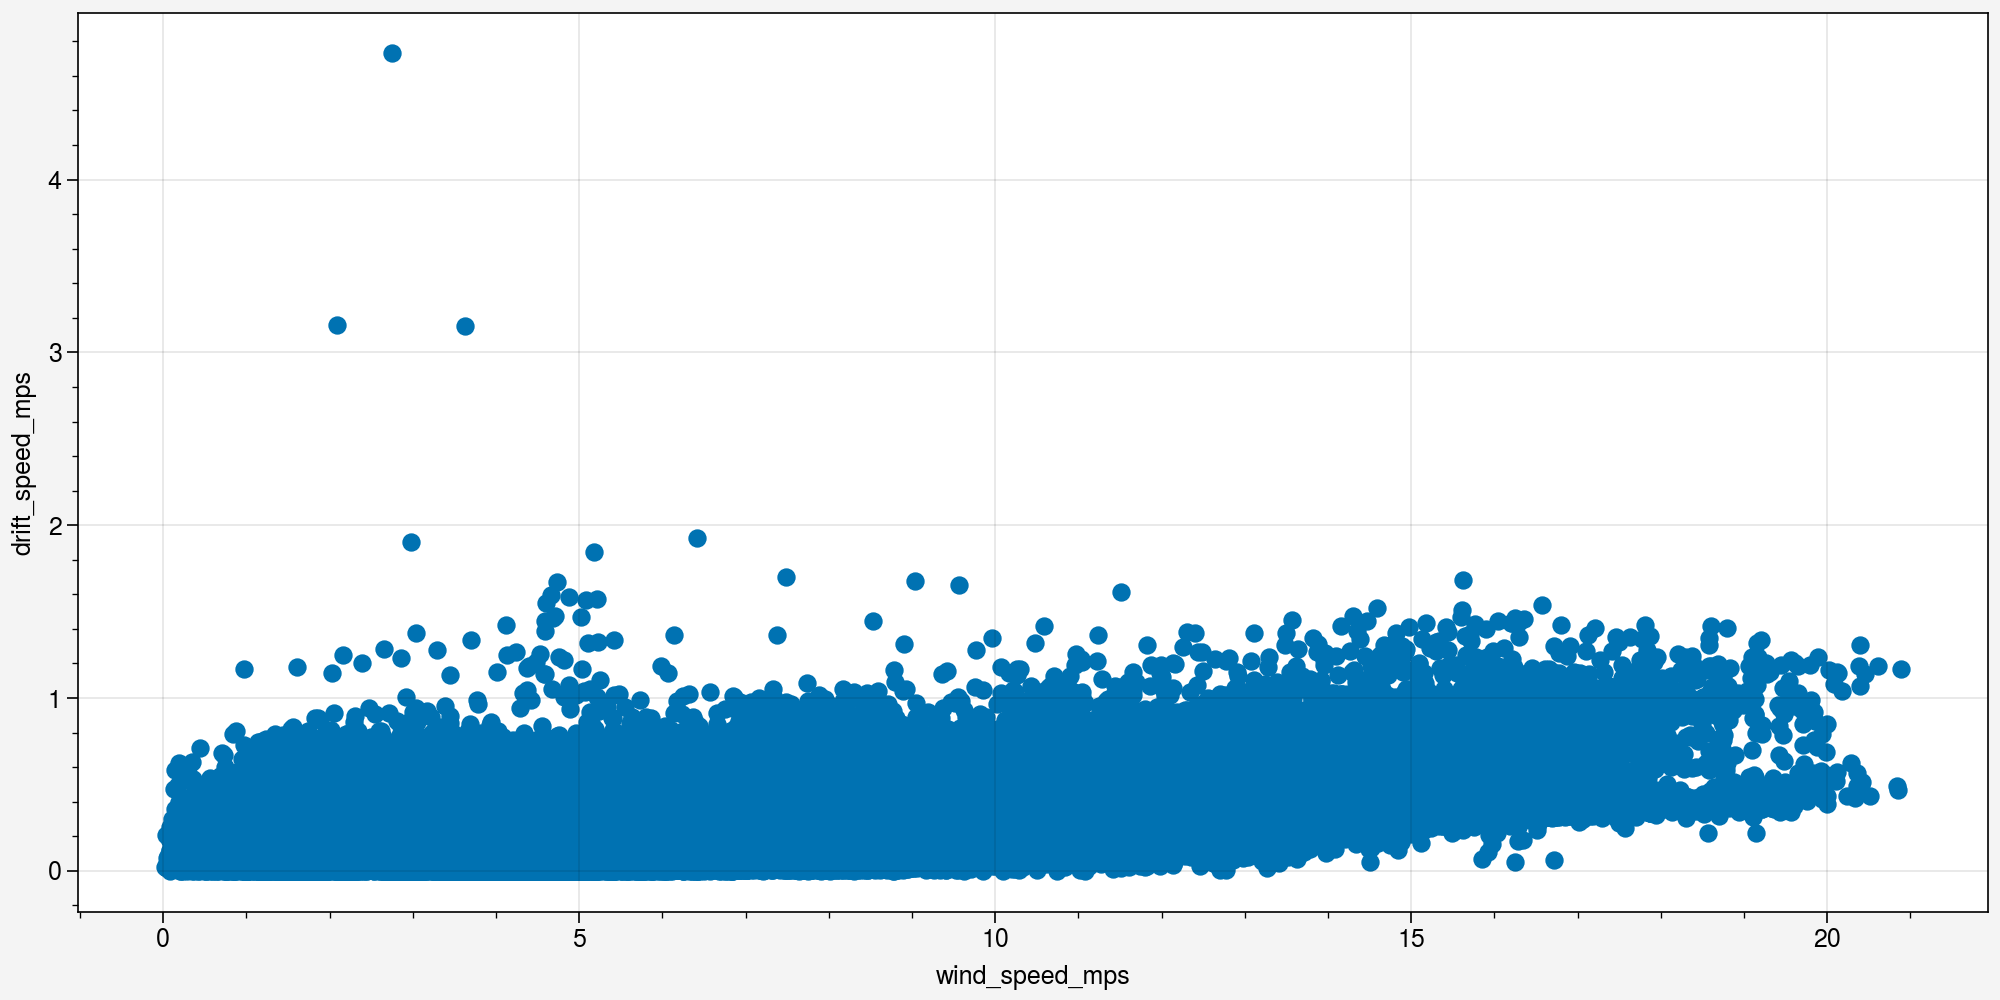

In [114]:
fig, ax = pplt.subplots(figsize=(10,5))
ax.scatter(df.wind_speed_mps, df.drift_speed_mps)